# Grid the data from PBO

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import itertools 
import functools
import pyproj
import numpy as np
import pandas as pd
import verde as vd
from dask.distributed import Client, LocalCluster
from vectorspline3d import VectorSpline3D, VectorSpline3DCV

In [2]:
#with open("../../data/pbo.final_igs08.vel") as infile:
with open("../../data/pbo.final_nam08.vel") as infile:
    print("File header:")
    for i, line in zip(range(35), infile):
        print(line, end="")
    columns = infile.readline().split()
    columns[0] = "Dot_number"
    data_raw = pd.read_csv(infile, delim_whitespace=True, names=columns)
data_raw.head()

File header:
PBO Velocity file from PBO_vel_171202_NAM08.org Reference Frame : NAM08
Format Version: 1.1.0
Release Date  : 20171227151532
Start Field Description
Dot#        4-character identifier for a given station
Name        16-character station name
Ref_epoch   Date and time at which the station position is as given in ref_XYZ and ref_NEU. Format is YYYYMMDDhhmmss.
Ref_jday    Reference epoch, represented as Modified Julian Day number (MJD)
Ref_X       Reference X coordinate at Ref_epoch, meters
Ref_Y       Reference Y coordinate at Ref_epoch, meters
Ref_Z       Reference Z coordinate at Ref_epoch, meters
Ref_Nlat    Reference North latitude WGS-84 ellipsoid, decimal degrees
Ref_Elong   Reference East Longitude WGS-84 ellipsoid, decimal degrees
Ref_Up      Referemce Height  WGS-84 ellipsoid, meters
dX/dt       X component of station velocity, meters/yr
dY/dt       Y component of station velocity, meters/yr
dZ/dt       Z component of station velocity, meters/yr
SXd         Standard

,Dot_number,Name,Ref_epoch,Ref_jday,Ref_X,Ref_Y,Ref_Z,Ref_Nlat,Ref_Elong,Ref_Up...,...,dE/dt,dU/dt,SNd,SEd,SUd,Rne,Rnu,Reu,first_epoch,last_epoch
0,1LSU,Louisiana_St,20171129120000,58086.5,-113402.86448,-5.504361e+06,3.209404e+06,30.407425,268.819738,-6.56355,...,-0.00030,-0.00282,0.00022,0.00042,0.00046,0.029,0.0,-0.007,20030423000000,20080621000000
1,1LSU,Louisiana_St,20171129120000,58086.5,-113402.86020,-5.504361e+06,3.209404e+06,30.407425,268.819738,-6.56999,...,-0.00030,-0.00282,0.00022,0.00042,0.00046,0.029,0.0,-0.007,20080623000000,20100415000000
2,1LSU,Louisiana_St,20171129120000,58086.5,-113402.86186,-5.504361e+06,3.209404e+06,30.407425,268.819738,-6.57409,...,-0.00030,-0.00282,0.00022,0.00042,0.00046,0.029,0.0,-0.007,20100415000000,20140115000000
3,1LSU,Louisiana_St,20171129120000,58086.5,-113402.87074,-5.504361e+06,3.209404e+06,30.407425,268.819738,-6.56938,...,-0.00030,-0.00282,0.00022,0.00042,0.00046,0.029,0.0,-0.007,20140115000000,20171203000000
4,1NSU,Northwestern,20171129120000,58086.5,-293349.50638,-5.420742e+06,3.336981e+06,31.750801,266.902397,28.05982,...,-0.00016,-0.00045,0.00026,0.00011,0.00047,-0.056,-0.0,0.038,20040116000000,20100730000000


In [3]:
inside = vd.inside(
    (data_raw["Ref_Elong"], data_raw["Ref_Nlat"]), 
    region=(230, 246, 30, 50)
)
data = data_raw[inside]
print(data.shape)
coordinates = (data["Ref_Elong"].values, data["Ref_Nlat"].values)
components = (data["dE/dt"].values*1000, data["dN/dt"].values*1000, data["dU/dt"].values*1000)
uncertainty = (data["SEd"].values*1000, data["SNd"].values*1000, data["SUd"].values*1000)
region = vd.get_region(coordinates)

(2938, 30)


AttributeError: 'property' object has no attribute 'get'

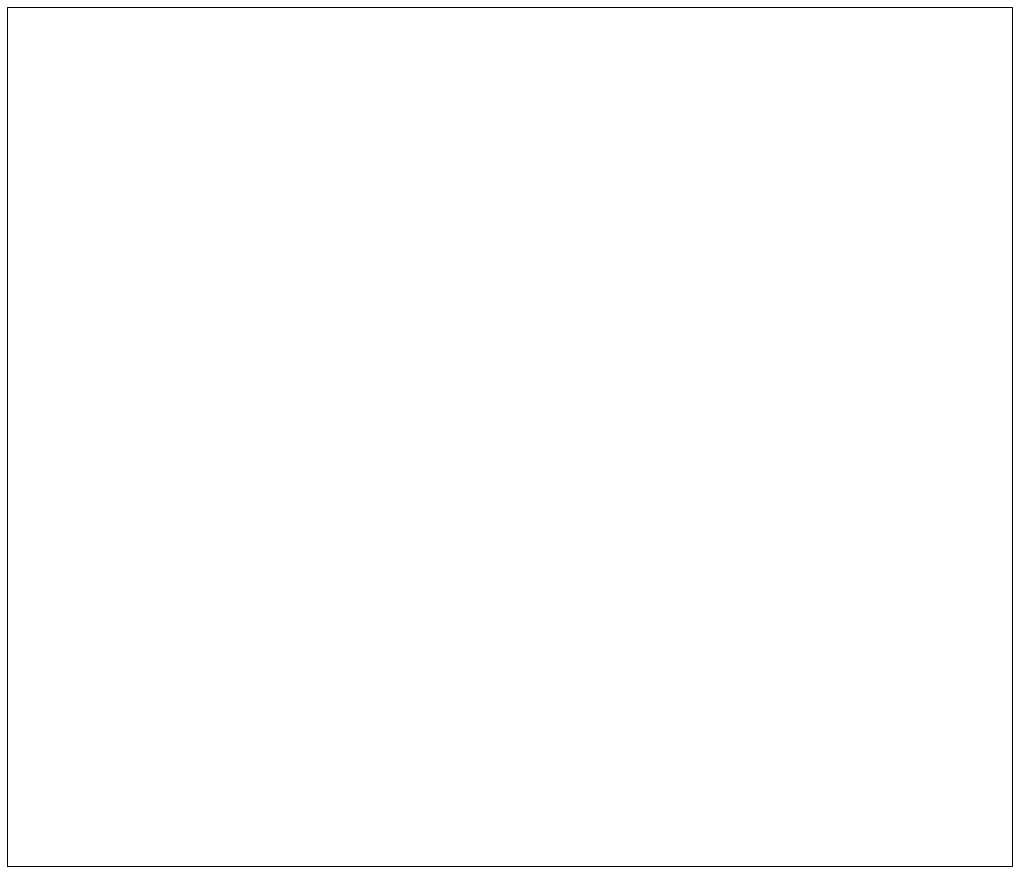

In [15]:
crs = ccrs.Mercator(
    central_longitude=np.mean(coordinates[0])
)
transform = ccrs.PlateCarree()

plt.figure(figsize=(18, 16))
ax = plt.subplot(111, projection=crs)

ax.add_feature(cfeature.LAND, facecolor="gray")
ax.add_feature(cfeature.OCEAN, facecolor="skyblue")
#ax.add_feature(cfeature.BORDERS, linewidth=0.1)
#ax.set_extent(region, crs=crs)

maxabs = 20
cmap = plt.cm.seismic
cbargs = dict(orientation="horizontal", aspect=70, shrink=0.7, pad=0.01,
              label="vertical velocity [mm/yr]")

tmp = ax.scatter(*coordinates, c=components[-1], s=30, alpha=1, cmap=cmap,
                 vmin=-maxabs, vmax=maxabs, transform=transform)
plt.colorbar(tmp, ax=ax, **cbargs)
ax.quiver(*coordinates, *components[:2], scale=400, width=0.0003, 
          transform=transform)
ax.gridlines(draw_labels=True, linewidth=0)
plt.tight_layout()

In [5]:
projection = pyproj.Proj(proj="aea", lon_0=np.mean(coordinates[0]))
proj_coords = projection(*coordinates)

In [6]:
np.linalg.norm(components[-1])/np.linalg.norm(components[0])

0.4074948818913242

In [7]:
weights = tuple(w*vd.variance_to_weights(i**2) 
                for i, w in zip(uncertainty, [0.001, 0.001, 1]))
train, test = vd.train_test_split(proj_coords, components, weights=weights, random_state=0)
print(train[0][0].size, test[0][0].size)

2644 294


In [8]:
spacing = 1/60
blockmean = vd.BlockReduce(np.mean, spacing=spacing*111e3, center_coordinates=True)
force_coords, _ = blockmean.filter(proj_coords, np.ones(data.shape[0]))
print(force_coords[0].size)
print(20/spacing)

1049
1200.0


In [9]:
client = Client(LocalCluster(n_workers=4))
client

Client Scheduler: tcp://127.0.0.1:38903 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 16.70 GB


In [10]:
%%time
spline = VectorSpline3DCV(
    poissons=(-1, -0.5, 0, 0.1, 0.2, 0.3, 0.4, 0.5), 
    depths=(5e3, 10e3, 20e3, 30e3, 40e3, 50e3),
    dampings=(1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1), 
    force_coords=None,
    client=client,
)
#spline = vd.Vector([vd.Spline(mindist=50e3, damping=1e-8, force_coords=force_coords) for i in range(3)])
spline.fit(proj_coords, components, weights)
print(spline.poisson_, spline.depth_, spline.damping_)
print(np.max(spline.scores_))

0.4 10000.0 0.1
0.92125266595503
CPU times: user 8min 40s, sys: 37.5 s, total: 9min 17s
Wall time: 37min 22s


In [11]:
grid = spline.grid(
    region=region, spacing=spacing, projection=projection,
    dims=["latitude", "longitude"],
    data_names=["east_velocity", "north_velocity", "up_velocity"]
)
grid = vd.distance_mask(coordinates, maxdist=100e3, grid=grid, projection=projection)

/home/leo/miniconda3/envs/agu2018/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1752: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/leo/miniconda3/envs/agu2018/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1752: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/leo/miniconda3/envs/agu2018/lib/python3.6/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


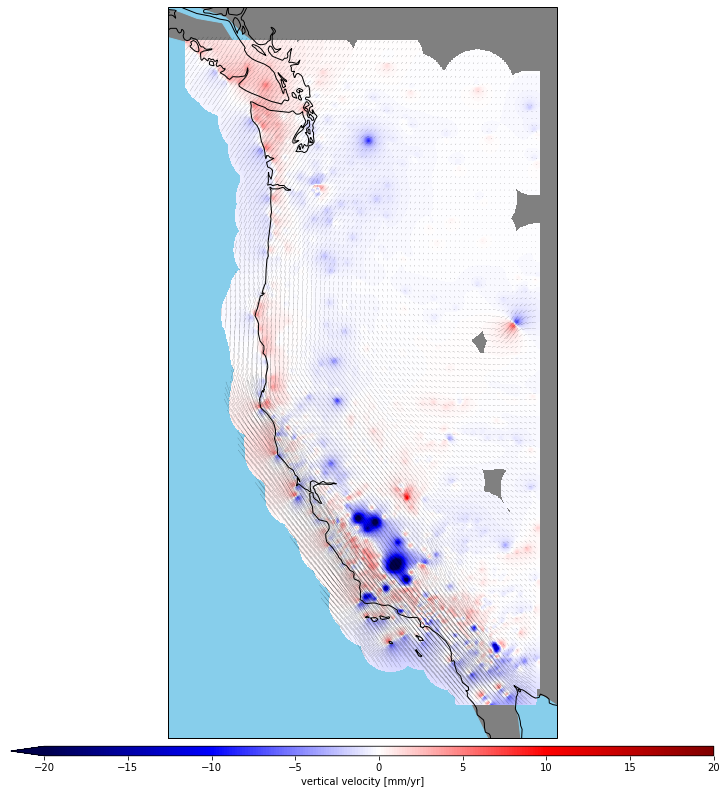

In [12]:
plt.figure(figsize=(18, 16))
ax = plt.subplot(111, projection=crs)

ax.add_feature(cfeature.LAND, facecolor="gray")
ax.add_feature(cfeature.OCEAN, facecolor="skyblue")

grid.up_velocity.plot.pcolormesh(
    ax=ax, cmap=cmap, vmin=-maxabs, vmax=maxabs, transform=transform,
    cbar_kwargs=cbargs
)
indexer = slice(None, None, 10)
# Downsample the arrows so we can actually see something
down = grid.isel(longitude=indexer, latitude=indexer)
ax.quiver(down.longitude.values, down.latitude.values, 
          down.east_velocity.values, down.north_velocity.values, 
          scale=400, width=0.0003, transform=transform)
#ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.coastlines(linewidth=1, resolution="50m")
plt.tight_layout()

In [13]:
predicted = spline.predict(proj_coords)
residuals = tuple(i - j for i, j in zip(components, predicted))

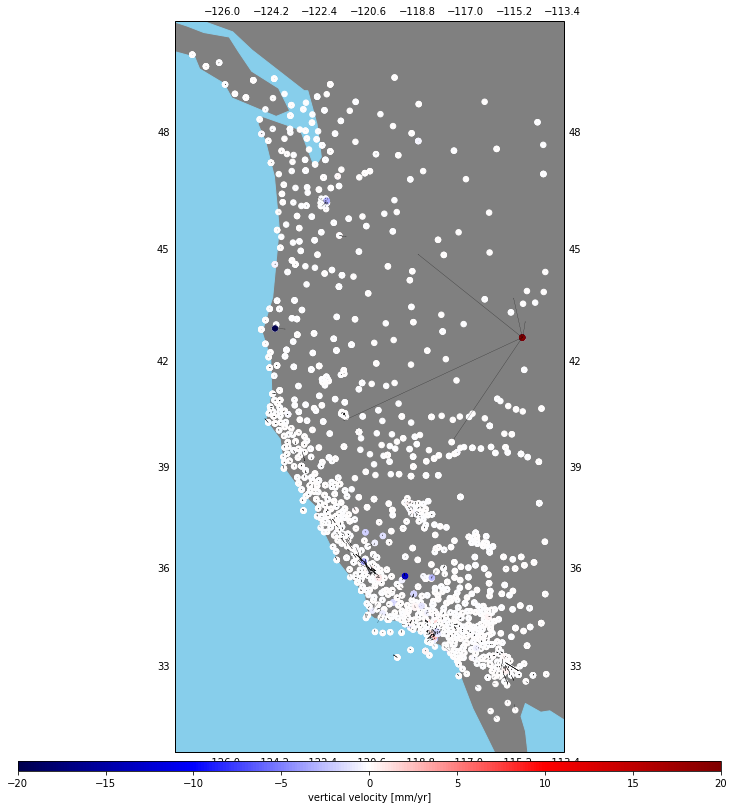

In [14]:
plt.figure(figsize=(18, 16))
ax = plt.subplot(111, projection=crs)

ax.add_feature(cfeature.LAND, facecolor="gray")
ax.add_feature(cfeature.OCEAN, facecolor="skyblue")

maxabs = 20
cmap = plt.cm.seismic
cbargs = dict(orientation="horizontal", aspect=70, shrink=0.7, pad=0.01,
              label="vertical velocity [mm/yr]")

tmp = ax.scatter(*coordinates, c=residuals[-1], s=30, alpha=1, cmap=cmap,
                 vmin=-maxabs, vmax=maxabs, transform=transform)
plt.colorbar(tmp, ax=ax, **cbargs)
ax.quiver(*coordinates, *residuals[:2], scale=400, width=0.0005, 
          transform=transform)
ax.gridlines(draw_labels=True, linewidth=0)
plt.tight_layout()